[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aderdouri/PINNs/blob/master/Tutorials/0-Schrodinger.ipynb)

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

import requests
import scipy.io
import torch
import io

In [35]:
# Step 1: GitHub raw URL to the .mat file
url = "https://github.com/maziarraissi/PINNs/raw/master/appendix/Data/burgers_shock.mat"

# Step 2: Download the file content
response = requests.get(url)
response.raise_for_status()  # Ensure the request was successful

# Step 3: Load the .mat file into memory
mat_data = scipy.io.loadmat(io.BytesIO(response.content))

# Step 4: Inspect the keys in the .mat file
print("Keys in the .mat file:", mat_data.keys())

# Step 5: Extract specific variables and convert to PyTorch tensors
usol = torch.tensor(mat_data['usol'], dtype=torch.float32)  # Solution variable
x = torch.tensor(mat_data['x'], dtype=torch.float32)        # Spatial grid
t = torch.tensor(mat_data['t'], dtype=torch.float32)        # Time grid

# Step 6: Print shapes of the loaded tensors
print(f"Shape of u(x, t): {usol.shape}")
print(f"Shape of x: {x.shape}")
print(f"Shape of t: {t.shape}")

Keys in the .mat file: dict_keys(['__header__', '__version__', '__globals__', 'x', 't', 'usol'])
Shape of u(x, t): torch.Size([256, 100])
Shape of x: torch.Size([256, 1])
Shape of t: torch.Size([100, 1])


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# Helper functions for gradients
def gradients(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    return torch.autograd.grad(y, x, grad_outputs=grad_outputs, create_graph=True, retain_graph=True)[0]

# Define Physics-Informed Neural Network (PINN)
class PhysicsInformedNN(nn.Module):
    def __init__(self, layers, lb, ub, dt, q):
        super(PhysicsInformedNN, self).__init__()
        self.lb = torch.tensor(lb, dtype=torch.float32)
        self.ub = torch.tensor(ub, dtype=torch.float32)
        self.dt = torch.tensor(dt, dtype=torch.float32)
        self.q = max(q, 1)

        # Neural network layers
        self.network = self.build_network(layers)

        # IRK weights
        self.IRK_weights, self.IRK_times = self.load_irk_weights(q)

    def build_network(self, layers):
        layers_list = []
        for i in range(len(layers) - 1):
            layers_list.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                layers_list.append(nn.Tanh())
        return nn.Sequential(*layers_list)

    def load_irk_weights(self, q):
        # Load IRK weights from GitHub
        url = f"https://raw.githubusercontent.com/maziarraissi/PINNs/master/Utilities/IRK_weights/Butcher_IRK{q}.txt"
        response = requests.get(url)
        response.raise_for_status()
        irk_data = np.loadtxt(io.StringIO(response.text), ndmin=2).astype(np.float32)
        IRK_weights = torch.tensor(irk_data[:q ** 2 + q].reshape((q + 1, q)), dtype=torch.float32)
        IRK_times = torch.tensor(irk_data[q ** 2 + q:], dtype=torch.float32)
        return IRK_weights, IRK_times

    def normalize(self, x):
        return 2.0 * (x - self.lb) / (self.ub - self.lb) - 1.0

    def forward(self, x):
        x_normalized = self.normalize(x)
        return self.network(x_normalized)

    def compute_u0(self, x0):
        nu = 0.01 / np.pi
        U1 = self.forward(x0)
        U = U1[:, :-1]
        U_x = gradients(U, x0)
        U_xx = gradients(U_x, x0)
        F = -U * U_x + nu * U_xx
        U0 = U1 - self.dt * torch.matmul(F, self.IRK_weights.T)
        return U0

    def compute_u1(self, x1):
        return self.forward(x1)

In [37]:
# Training Function
def train_with_adam_and_lbfgs(model, optimizer_adam, x0, u0, x1, epochs_adam=1000, lbfgs_max_iter=500):
    # Adam optimization
    for epoch in range(epochs_adam):
        optimizer_adam.zero_grad()

        # Compute predictions
        U0_pred = model.compute_u0(x0)
        U1_pred = model.compute_u1(x1)

        # Compute losses
        loss_u0 = torch.mean((u0 - U0_pred) ** 2)
        loss_u1 = torch.mean(U1_pred ** 2)
        loss = loss_u0 + loss_u1

        # Backpropagation and optimization
        loss.backward()
        optimizer_adam.step()

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Adam Loss: {loss.item():.3e}")

    # L-BFGS optimization
    optimizer_lbfgs = optim.LBFGS(
        model.parameters(),
        max_iter=lbfgs_max_iter,
        history_size=50,
        line_search_fn="strong_wolfe",
        tolerance_grad=1e-7,
        tolerance_change=1e-9
    )

    def closure():
        optimizer_lbfgs.zero_grad()

        # Compute predictions
        U0_pred = model.compute_u0(x0)
        U1_pred = model.compute_u1(x1)

        # Compute losses
        loss_u0 = torch.mean((u0 - U0_pred) ** 2)
        loss_u1 = torch.mean(U1_pred ** 2)
        loss = loss_u0 + loss_u1

        # Backpropagation
        loss.backward()
        return loss

    optimizer_lbfgs.step(closure)
    final_loss = closure().item()
    print(f"L-BFGS Final Loss: {final_loss:.3e}")

# Prediction Function
def predict(model, x_star):
    return model.compute_u1(x_star).detach().numpy()

In [ ]:
# Load data
data = mat_data #loadmat('../Data/burgers_shock.mat')
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T

# Settings
q = 500
layers = [1, 50, 50, 50, q + 1]
lb = [-1.0]
ub = [1.0]
N = 250

# Data Preparation
idx_t0 = 10
idx_t1 = 90
dt = t[idx_t1] - t[idx_t0]

idx_x = np.random.choice(Exact.shape[1], N, replace=False)
x0 = torch.tensor(x[idx_x, :], dtype=torch.float32, requires_grad=True)
u0 = torch.tensor(Exact[idx_t0:idx_t0 + 1, idx_x].T, dtype=torch.float32)

x1 = torch.tensor(np.vstack((lb, ub)), dtype=torch.float32, requires_grad=True)
x_star = torch.tensor(x, dtype=torch.float32)

# Initialize Model and Optimizer
model = PhysicsInformedNN(layers, lb, ub, dt, q)
optimizer = optim.Adam(model.parameters(), lr=0.001)



# Initialize model and optimizers
model = PhysicsInformedNN(layers, lb, ub, dt, q)
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

# Train model with Adam followed by L-BFGS
train_with_adam_and_lbfgs(model, optimizer_adam, x0, u0, x1,
                          epochs_adam=10000,
                          lbfgs_max_iter=50000)

# Prediction and Evaluation
U1_pred = predict(model, x_star)
error = np.linalg.norm(U1_pred[:, -1] - Exact[idx_t1, :], 2) / np.linalg.norm(Exact[idx_t1, :], 2)
print(f"Error: {error:.3e}")

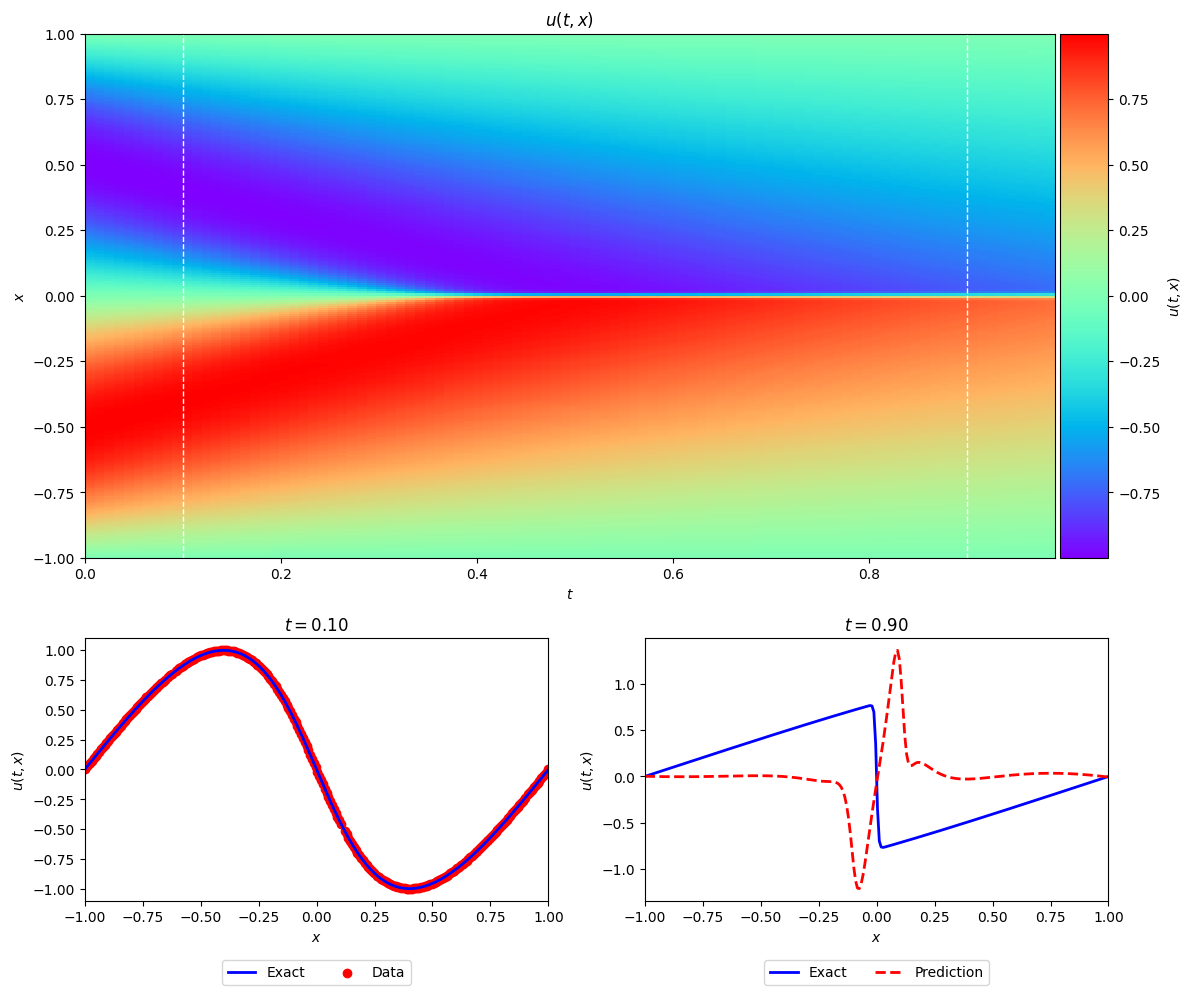

In [43]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure with gridspec layout
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1])

# Top Panel: Heatmap of u(t, x)
ax0 = plt.subplot(gs[0, :])
heatmap = ax0.imshow(Exact.T, interpolation='nearest', cmap='rainbow',
                     extent=[t.min(), t.max(), x.min(), x.max()],
                     origin='lower', aspect='auto')
divider = make_axes_locatable(ax0)
cbar = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(heatmap, cax=cbar, label="$u(t, x)$")
ax0.plot([t[idx_t0], t[idx_t0]], [x.min(), x.max()], 'w--', linewidth=1)  # Vertical line for t0
ax0.plot([t[idx_t1], t[idx_t1]], [x.min(), x.max()], 'w--', linewidth=1)  # Vertical line for t1
ax0.set_xlabel("$t$")
ax0.set_ylabel("$x$")
ax0.set_title("$u(t, x)$")

# Bottom Left Panel: t = t0
ax1 = plt.subplot(gs[1, 0])
ax1.plot(x, Exact[idx_t0, :], 'b-', linewidth=2, label='Exact')  # Exact solution
ax1.scatter(x0.detach().numpy(), u0.detach().numpy(), color='red', label='Data')  # Training data
ax1.set_xlabel("$x$")
ax1.set_ylabel("$u(t, x)$")
ax1.set_xlim([x.min(), x.max()])
ax1.set_title(f"$t = {t[idx_t0, 0]:.2f}$")
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)

# Bottom Right Panel: t = t1
ax2 = plt.subplot(gs[1, 1])
ax2.plot(x, Exact[idx_t1, :], 'b-', linewidth=2, label='Exact')  # Exact solution
ax2.plot(x_star.detach().numpy(), U1_pred[:, -1], 'r--', linewidth=2, label='Prediction')  # Prediction
ax2.set_xlabel("$x$")
ax2.set_ylabel("$u(t, x)$")
ax2.set_xlim([x.min(), x.max()])
ax2.set_title(f"$t = {t[idx_t1, 0]:.2f}$")
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)

plt.tight_layout()
plt.show()
